In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import yfinance as yf
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, precision_score, recall_score
from alpha_vantage.timeseries import TimeSeries
import time
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import RandomizedSearchCV
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Dense, Dropout, Input, LSTM, BatchNormalization

In [4]:
# Define stock tickers for analysis and fetching data of multiple stocks

In [5]:
tickers = ["TSLA", "AAPL", "MSFT", "GOOGL", "AMZN" ,"ORCL" ,"INTC" ,"NVDA" ,"META" ,"BABA"]  # Add more tickers as needed

In [6]:
# Function to fetch intraday data for multiple stocks

In [7]:
def fetch_stock_data(ticker):                                             # Using yahoo finance
    data = yf.download(ticker, interval='1d', period='3mo') # if error occurs at train test size i.e. it says no data then changle interval to '5m' and period to '5d'
    data.columns = ['open', 'high', 'low', 'close', 'adj_close', 'volume']
    data['Return'] = data['close'].pct_change()
    data['Target'] = (data['close'].shift(-1) > data['close']).astype(int)
    data.dropna(inplace=True)
    return data

In [8]:
# Fetch and process data for all tickers

In [9]:
all_data = {}
for ticker in tickers:
    all_data[ticker] = fetch_stock_data(ticker)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [10]:
all_data[tickers[0]].info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 62 entries, 2024-10-18 to 2025-01-17
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   open       62 non-null     float64
 1   high       62 non-null     float64
 2   low        62 non-null     float64
 3   close      62 non-null     float64
 4   adj_close  62 non-null     float64
 5   volume     62 non-null     int64  
 6   Return     62 non-null     float64
 7   Target     62 non-null     int32  
dtypes: float64(6), int32(1), int64(1)
memory usage: 4.1 KB


In [11]:
all_data[tickers[0]].head()

,open,high,low,close,adj_close,volume,Return,Target
Date,,,,,,,,
2024-10-18,220.699997,220.699997,222.279999,219.229996,220.710007,49611900,0.006104,0
2024-10-21,218.850006,218.850006,220.479996,215.729996,218.899994,47329000,-0.015965,0
2024-10-22,217.970001,217.970001,218.220001,215.259995,217.309998,43268700,-0.002179,0
2024-10-23,213.649994,213.649994,218.720001,212.110001,217.130005,80938900,-0.014633,1
2024-10-24,260.480011,260.480011,262.119995,242.649994,244.679993,204491900,0.143982,1


In [12]:
all_data[tickers[0]].tail()

,open,high,low,close,adj_close,volume,Return,Target
Date,,,,,,,,
2025-01-13,403.309998,403.309998,403.790009,380.070007,383.209991,67580500,0.007368,1
2025-01-14,396.359985,396.359985,422.640015,394.540009,414.339996,84565000,0.038072,1
2025-01-15,428.220001,428.220001,429.799988,405.660004,409.899994,81375500,0.028185,1
2025-01-16,413.820007,413.820007,424.000000,409.130005,423.489990,68335200,0.008554,1
2025-01-17,437.674591,437.674591,439.739990,419.770111,421.720001,69823479,0.026007,0


In [16]:
# Creating features and target for Machine learning

In [17]:
def compute_rsi(series, period=14):
    delta = series.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=period).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=period).mean()
    rs = gain / loss
    return 100 - (100 / (1 + rs))

In [18]:
def add_technical_indicators(data):
    data['SMA_5'] = data['close'].rolling(window=5).mean()
    data['SMA_20'] = data['close'].rolling(window=20).mean()
    data['RSI'] = compute_rsi(data['close'])
    data['Bollinger_Upper'] = data['SMA_20'] + 2 * data['close'].rolling(window=20).std()
    data['Bollinger_Lower'] = data['SMA_20'] - 2 * data['close'].rolling(window=20).std()
    data['Volume_Change'] = data['volume'].pct_change()
    data.dropna(inplace=True)
    return data

In [19]:
for ticker in tickers:
    all_data[ticker] = add_technical_indicators(all_data[ticker])

In [20]:
combined_data = pd.concat([df.assign(ticker=ticker) for ticker, df in all_data.items()])
X = combined_data[['Return', 'SMA_5', 'SMA_20', 'RSI', 'Bollinger_Upper', 'Bollinger_Lower', 'Volume_Change']]
y = combined_data['Target']

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

In [22]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [23]:
#Using GradientBoostingClassifier(HYperparameter tuning included)

In [24]:
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

In [25]:
gb_model = GradientBoostingClassifier()
grid_search = GridSearchCV(estimator=gb_model, param_grid=param_grid, scoring='f1', cv=TimeSeriesSplit(n_splits=5), verbose=1, n_jobs=-1)
grid_search.fit(X_train, y_train)
print("Best parameters for Gradient Boosting: ", grid_search.best_params_)

Fitting 5 folds for each of 243 candidates, totalling 1215 fits
Best parameters for Gradient Boosting:  {'learning_rate': 0.01, 'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}


In [26]:
# Cross-Validation for Gradient Boosting
cv_scores = cross_val_score(gb_model, X, y, cv=5, scoring='f1')
print("Cross-Validation F1 Scores for Gradient Boosting: ", cv_scores)
print("Mean F1 Score: ", np.mean(cv_scores))

Cross-Validation F1 Scores for Gradient Boosting:  [0.59459459 0.35714286 0.175      0.31168831 0.44705882]
Mean F1 Score:  0.37709691739103507


In [27]:
gb_hyp_model = GradientBoostingClassifier(**grid_search.best_params_)
gb_hyp_model.fit(X_train, y_train)

GradientBoostingClassifier(learning_rate=0.01, max_depth=5, min_samples_leaf=2,
                           min_samples_split=5)

In [28]:
cv_scores = cross_val_score(gb_hyp_model, X, y, cv=5, scoring='f1')
print("Cross-Validation F1 Scores for Gradient Boosting(tuned): ", cv_scores)
print("Mean F1 Score: ", np.mean(cv_scores))

Cross-Validation F1 Scores for Gradient Boosting(tuned):  [0.65546218 0.46315789 0.40449438 0.37777778 0.40449438]
Mean F1 Score:  0.46107732428670267


In [29]:
predictions_gb_hyp = gb_hyp_model.predict(X_test)

accuracy = accuracy_score(y_test, predictions_gb_hyp)
f1 = f1_score(y_test, predictions_gb_hyp)
precision = precision_score(y_test, predictions_gb_hyp)
recall = recall_score(y_test, predictions_gb_hyp)

print(f"Gradient Boosting Model Accuracy: {accuracy:.2f}")
print(f"Gradient Boosting F1 Score: {f1:.2f}")
print(f"Gradient Boosting Precision: {precision:.2f}")
print(f"Gradient Boosting Recall: {recall:.2f}")

Gradient Boosting Model Accuracy: 0.51
Gradient Boosting F1 Score: 0.55
Gradient Boosting Precision: 0.55
Gradient Boosting Recall: 0.55


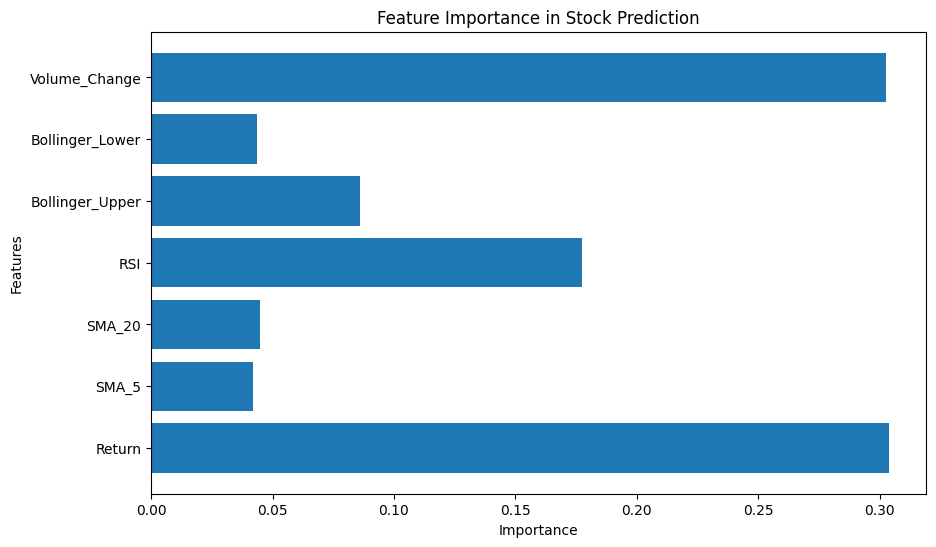

In [30]:
plt.figure(figsize=(10, 6))
plt.barh(X.columns, gb_hyp_model.feature_importances_)
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title('Feature Importance in Stock Prediction')
plt.show()

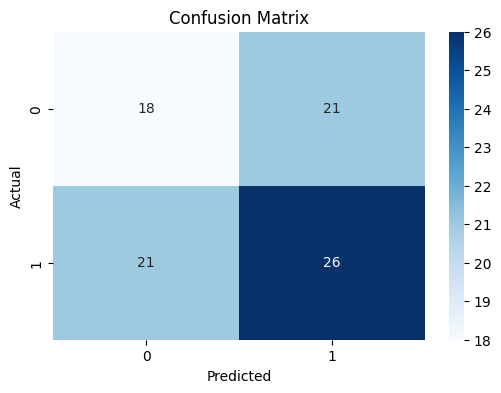

In [31]:
conf_matrix = confusion_matrix(y_test, predictions_gb_hyp)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [32]:
def predict_trending_stocks(data, model, scaler):
    tomorrow_predictions = {}
    for ticker in tickers:
        stock_data = data[ticker]
        if not stock_data.empty:
            X_future = stock_data[['Return', 'SMA_5', 'SMA_20', 'RSI', 'Bollinger_Upper', 'Bollinger_Lower', 'Volume_Change']].dropna().tail(1)
            if not X_future.empty:
                X_future_scaled = scaler.transform(X_future)
                prediction = model.predict(X_future_scaled)[0]
                tomorrow_predictions[ticker] = "Up" if prediction == 1 else "Down"
            else:
                tomorrow_predictions[ticker] = "No Data"
        else:
            tomorrow_predictions[ticker] = "No Data"
    return tomorrow_predictions

In [33]:
trending_stocks = predict_trending_stocks(all_data, gb_hyp_model, scaler)
print("Trending Stocks for Tomorrow:")
print(trending_stocks)

Trending Stocks for Tomorrow:
{'TSLA': 'Down', 'AAPL': 'Down', 'MSFT': 'Down', 'GOOGL': 'Down', 'AMZN': 'Up', 'ORCL': 'Down', 'INTC': 'Down', 'NVDA': 'Down', 'META': 'Down', 'BABA': 'Down'}


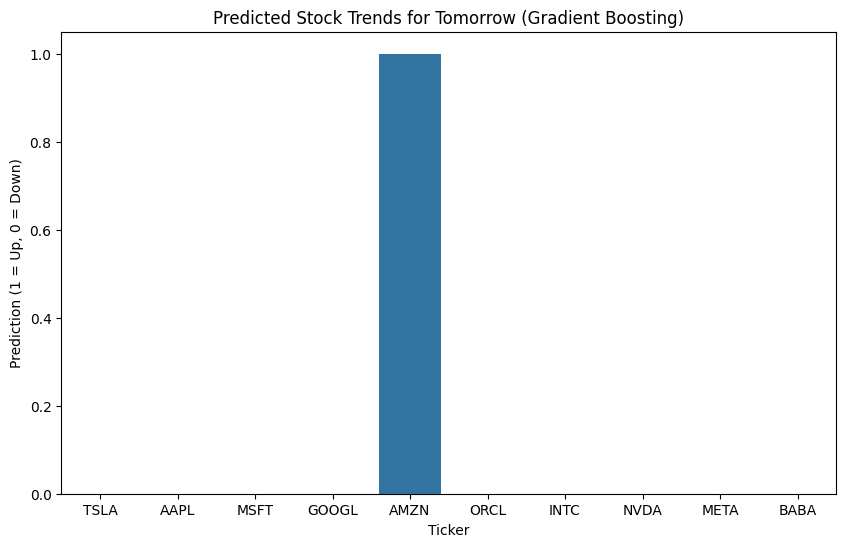

In [34]:
plt.figure(figsize=(10, 6))
trending_df = pd.DataFrame(list(trending_stocks.items()), columns=['Ticker', 'Prediction'])
trending_df['Prediction'] = trending_df['Prediction'].map({'Up': 1, 'Down': 0, 'No Data': None})
sns.barplot(x='Ticker', y='Prediction', data=trending_df.dropna())
plt.ylabel('Prediction (1 = Up, 0 = Down)')
plt.title('Predicted Stock Trends for Tomorrow (Gradient Boosting)')
plt.show()

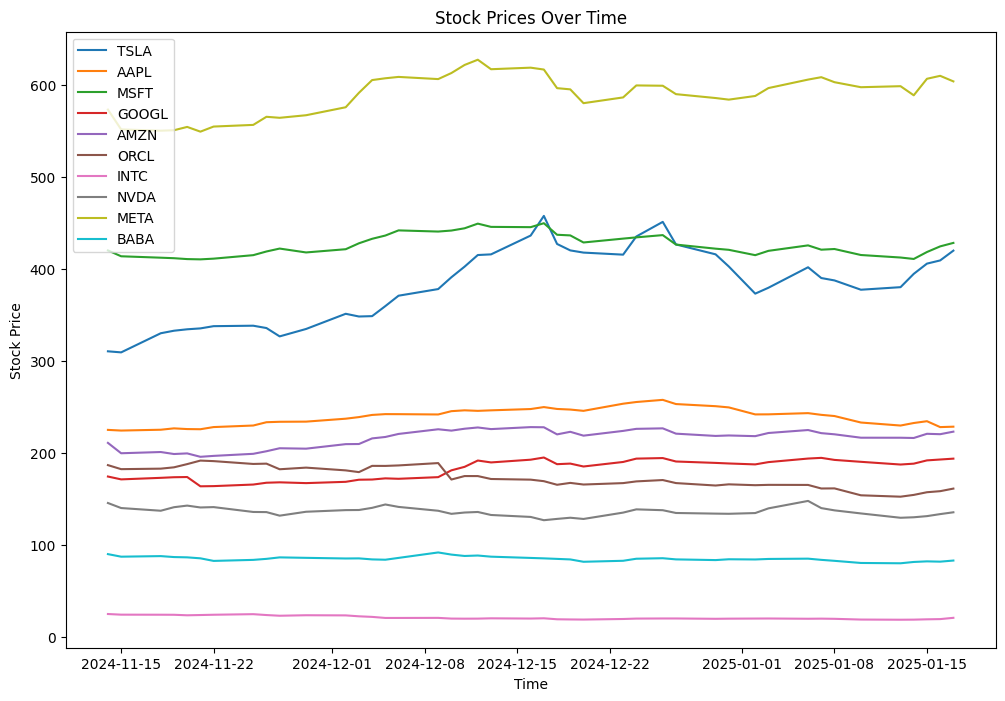

In [35]:
plt.figure(figsize=(12, 8))
for ticker in tickers:
    plt.plot(all_data[ticker].index, all_data[ticker]['close'], label=ticker)

plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.title('Stock Prices Over Time')
plt.legend()
plt.show()

In [36]:
#Using Tenserflow

In [37]:
#Using LSTM
def prepare_lstm_data(X, y, time_steps=1):
    X_lstm = []
    y_lstm = []
    for i in range(len(X) - time_steps):
        X_lstm.append(X[i:(i + time_steps)])
        y_lstm.append(y.iloc[i + time_steps])
    return np.array(X_lstm), np.array(y_lstm)

In [38]:
time_steps = 5  # You can adjust this
X_lstm, y_lstm = prepare_lstm_data(X_train, y_train, time_steps)
X_lstm_test, y_lstm_test = prepare_lstm_data(X_test, y_test, time_steps)

In [39]:
lstm_model = Sequential([
    Input(shape=(time_steps, X.shape[1])),
    LSTM(128, activation='relu', return_sequences=True),
    Dropout(0.3),
    BatchNormalization(),
    LSTM(64, activation='relu'),
    Dropout(0.3),
    BatchNormalization(),
    Dense(1, activation='sigmoid')
])

In [40]:
lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [41]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [42]:
history_lstm = lstm_model.fit(X_lstm, y_lstm, validation_split=0.2, epochs=30, batch_size=32, callbacks=[early_stopping])

Epoch 1/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 83ms/step - accuracy: 0.4723 - loss: 0.9462 - val_accuracy: 0.5441 - val_loss: 0.6929
Epoch 2/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.5465 - loss: 0.7885 - val_accuracy: 0.5147 - val_loss: 0.6922
Epoch 3/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.5836 - loss: 0.7042 - val_accuracy: 0.5294 - val_loss: 0.6917
Epoch 4/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.5094 - loss: 0.8359 - val_accuracy: 0.5294 - val_loss: 0.6916
Epoch 5/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.5981 - loss: 0.6841 - val_accuracy: 0.5294 - val_loss: 0.6917
Epoch 6/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.5992 - loss: 0.6780 - val_accuracy: 0.5294 - val_loss: 0.6917
Epoch 7/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.6340 - loss: 0.6563 - val_accuracy: 0.5294 - val_loss: 0.6918
Epoch 8/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.5923 - loss: 0.6825 - val_accuracy: 0.5294 - val_loss: 0.6921


In [43]:
lstm_loss, lstm_accuracy = lstm_model.evaluate(X_lstm_test, y_lstm_test)
print(f"LSTM Model Loss: {lstm_loss:.4f}")
print(f"LSTM Model Accuracy: {lstm_accuracy:.4f}")

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.5333 - loss: 0.6931
LSTM Model Loss: 0.6902
LSTM Model Accuracy: 0.5432


In [44]:
predictions_lstm = (lstm_model.predict(X_lstm_test) > 0.5).astype(int).flatten()

accuracy_lstm = accuracy_score(y_lstm_test, predictions_lstm)
f1_lstm = f1_score(y_lstm_test, predictions_lstm)
precision_lstm = precision_score(y_lstm_test, predictions_lstm)
recall_lstm = recall_score(y_lstm_test, predictions_lstm)

print(f"LSTM Model Accuracy: {accuracy_lstm:.2f}")
print(f"LSTM F1 Score: {f1_lstm:.2f}")
print(f"LSTM Precision: {precision_lstm:.2f}")
print(f"LSTM Recall: {recall_lstm:.2f}")

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 188ms/step
LSTM Model Accuracy: 0.54
LSTM F1 Score: 0.70
LSTM Precision: 0.54
LSTM Recall: 1.00


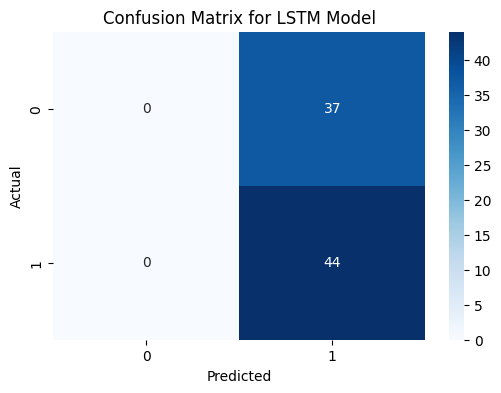

In [45]:
conf_matrix_lstm = confusion_matrix(y_lstm_test, predictions_lstm)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix_lstm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for LSTM Model')
plt.show()

In [46]:
def predict_trends_lstm(data, model, time_steps):
    tomorrow_predictions_lstm = {}
    for ticker in tickers:
        stock_data = data[ticker].tail(time_steps)
        if len(stock_data) >= time_steps:
            X_future = stock_data[['Return', 'SMA_5', 'SMA_20', 'RSI', 'Bollinger_Upper', 'Bollinger_Lower', 'Volume_Change']].tail(time_steps).values
            X_future = X_future.reshape((1, time_steps, X_future.shape[1]))
            prediction = model.predict(X_future)
            tomorrow_predictions_lstm[ticker] = "Up" if prediction > 0.5 else "Down"
        else:
            tomorrow_predictions_lstm[ticker] = "No Data"
    return tomorrow_predictions_lstm

In [47]:
trending_stocks_lstm = predict_trends_lstm(all_data, lstm_model, time_steps)
print("LSTM Predicted Trending Stocks for Tomorrow:")
print(trending_stocks_lstm)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
LSTM Predicted Trending Stocks for Tomorrow:
{'TSLA': 'Up', 'AAPL': 'Up', 'MSFT': 'Down', 'GOOGL': 'Up', 'AMZN': 'Down', 'ORCL': 'Up', 'INTC': 'Down', 'NVDA': 'Up', 'META': 'Down', 'BABA': 'Down'}


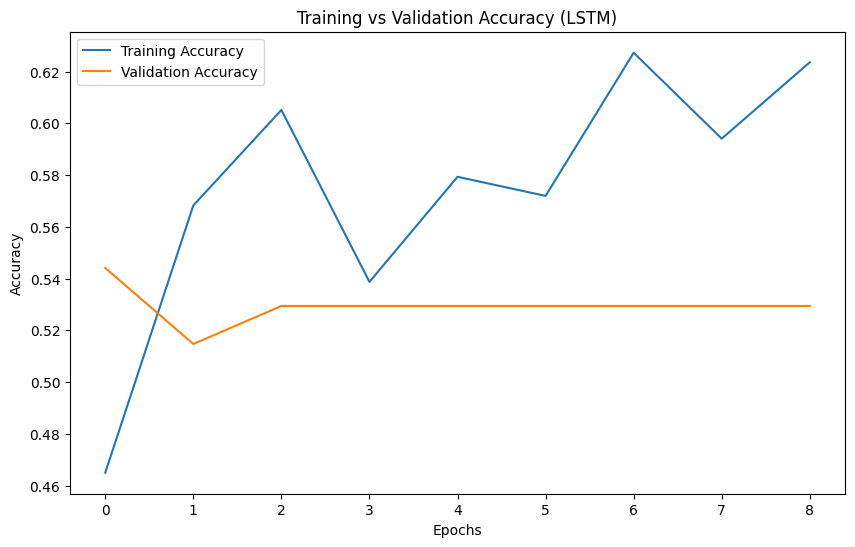

In [48]:
plt.figure(figsize=(10, 6))
plt.plot(history_lstm.history['accuracy'], label='Training Accuracy')
plt.plot(history_lstm.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy (LSTM)')
plt.legend()
plt.show()

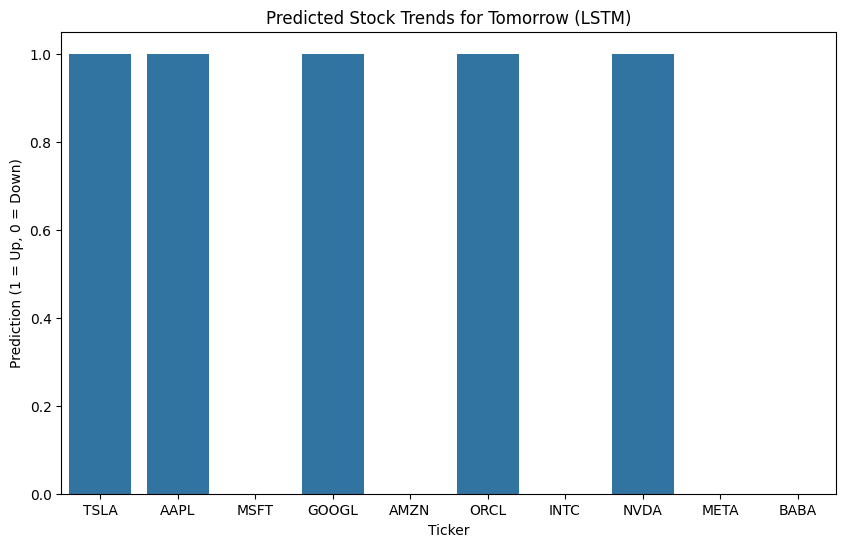

In [49]:
plt.figure(figsize=(10, 6))
trending_df_lstm = pd.DataFrame(list(trending_stocks_lstm.items()), columns=['Ticker', 'Prediction'])
trending_df_lstm['Prediction'] = trending_df_lstm['Prediction'].map({'Up': 1, 'Down': 0})
sns.barplot(x='Ticker', y='Prediction', data=trending_df_lstm.dropna())
plt.ylabel('Prediction (1 = Up, 0 = Down)')
plt.title('Predicted Stock Trends for Tomorrow (LSTM)')
plt.show()

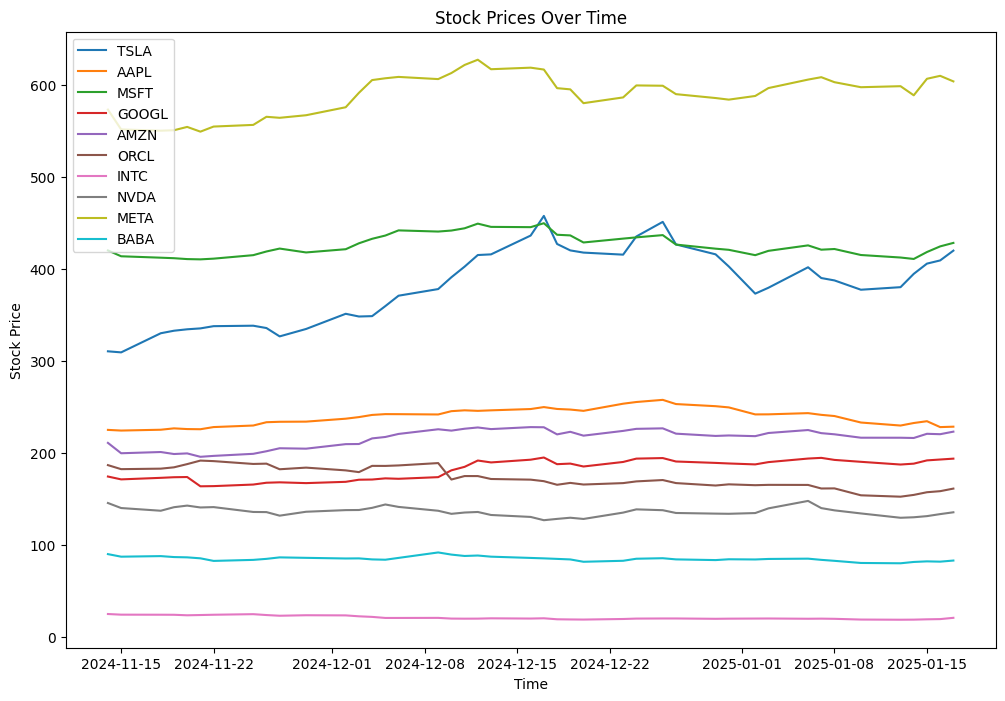

In [50]:
plt.figure(figsize=(12, 8))
for ticker in tickers:
    plt.plot(all_data[ticker].index, all_data[ticker]['close'], label=ticker)

plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.title('Stock Prices Over Time')
plt.legend()
plt.show()

In [51]:
#Dense Neural Network
dnn_model = Sequential([
    Input(shape=(X_train.shape[1],)),
    Dense(256),
    LeakyReLU(negative_slope=0.1),  # Update here
    Dropout(0.3),
    BatchNormalization(),
    Dense(128),
    LeakyReLU(negative_slope=0.1),  # Update here
    Dropout(0.2),
    BatchNormalization(),
    Dense(64),
    LeakyReLU(negative_slope=0.1),  # Update here
    Dense(1, activation='sigmoid')
])
dnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [52]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history_dnn = dnn_model.fit(X_train, y_train, validation_split=0.2, epochs=50, batch_size=32, callbacks=[early_stopping])

Epoch 1/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.5274 - loss: 0.8789 - val_accuracy: 0.4783 - val_loss: 0.7065
Epoch 2/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.5627 - loss: 0.8346 - val_accuracy: 0.4493 - val_loss: 0.7144
Epoch 3/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.5850 - loss: 0.7130 - val_accuracy: 0.4638 - val_loss: 0.7069
Epoch 4/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5573 - loss: 0.7345 - val_accuracy: 0.4493 - val_loss: 0.7046
Epoch 5/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.6104 - loss: 0.6936 - val_accuracy: 0.4638 - val_loss: 0.7061
Epoch 6/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.6009 - loss: 0.6806 - val_accuracy: 0.4783 - val_loss: 0.7059
Epoch 7/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.6094 - loss: 0.6359 - val_accuracy: 0.4638 - val_loss: 0.7063
Epoch 8/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5631 - loss: 0.6722 - val_accuracy: 0.5507 - val_loss: 0.6944


In [53]:
loss, accuracy = dnn_model.evaluate(X_test, y_test)
print(f"Dense Neural Network Model Accuracy: {accuracy:.2f}")

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.3853 - loss: 0.7149
Dense Neural Network Model Accuracy: 0.37


In [54]:
predictions_dnn = (dnn_model.predict(X_test) > 0.5).astype(int)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


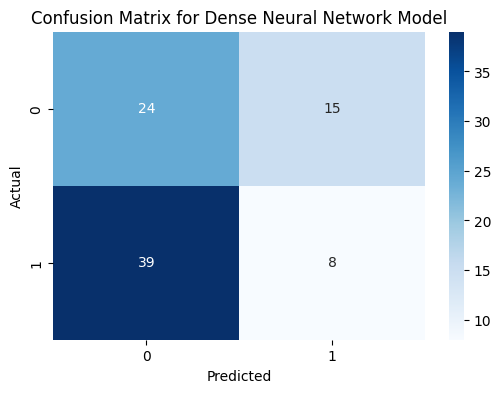

In [55]:
conf_matrix_dnn = confusion_matrix(y_test, predictions_dnn)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix_dnn, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Dense Neural Network Model')
plt.show()

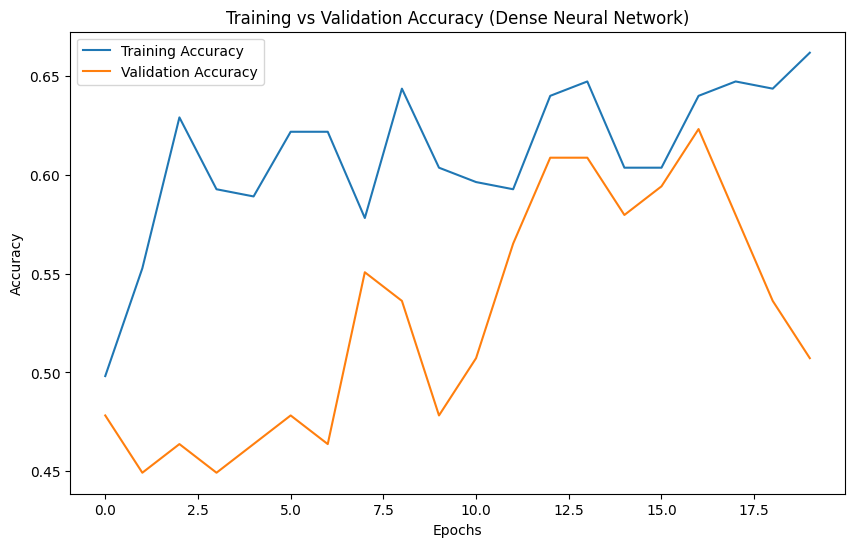

In [56]:
plt.figure(figsize=(10, 6))
plt.plot(history_dnn.history['accuracy'], label='Training Accuracy')
plt.plot(history_dnn.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy (Dense Neural Network)')
plt.legend()
plt.show()

In [57]:
def predict_trending_stocks_dnn(data, model, scaler):
    tomorrow_predictions = {}
    for ticker in tickers:
        stock_data = data[ticker]
        X_future = stock_data[['Return', 'SMA_5', 'SMA_20', 'RSI', 'Bollinger_Upper', 'Bollinger_Lower', 'Volume_Change']].dropna().tail(1)
        if not X_future.empty:
            X_future = scaler.transform(X_future)
            prediction = (model.predict(X_future) > 0.5).astype(int)[0][0]
            tomorrow_predictions[ticker] = "Up" if prediction == 1 else "Down"
        else:
            tomorrow_predictions[ticker] = "No Data"
    return tomorrow_predictions

In [58]:
trending_stocks_dnn = predict_trending_stocks_dnn(all_data, dnn_model, scaler)
print("Trending Stocks for Tomorrow (Dense Neural Network):")
print(trending_stocks_dnn)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Trending Stocks for Tomorrow (Dense Neural Network):
{'TSLA': 'Up', 'AAPL': 'Down', 'MSFT': 'Down', 'GOOGL': 'Up', 'AMZN': 'Up', 'ORCL': 'Up', 'INTC': 'Down', 'NVDA': 'Up', 'META': 'Down', 'BABA': 'Up'}


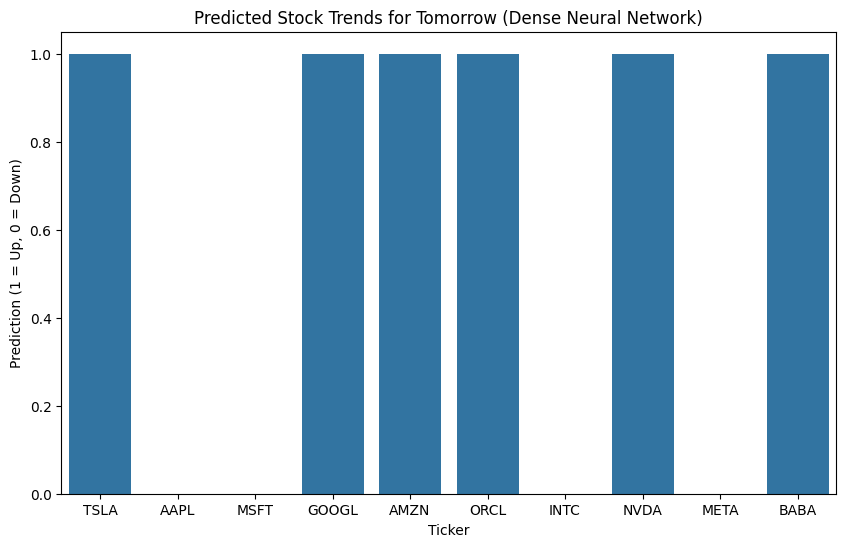

In [59]:
plt.figure(figsize=(10, 6))
trending_df_dnn = pd.DataFrame(list(trending_stocks_dnn.items()), columns=['Ticker', 'Prediction'])
trending_df_dnn['Prediction'] = trending_df_dnn['Prediction'].map({'Up': 1, 'Down': 0})
sns.barplot(x='Ticker', y='Prediction', data=trending_df_dnn.dropna())
plt.ylabel('Prediction (1 = Up, 0 = Down)')
plt.title('Predicted Stock Trends for Tomorrow (Dense Neural Network)')
plt.show()

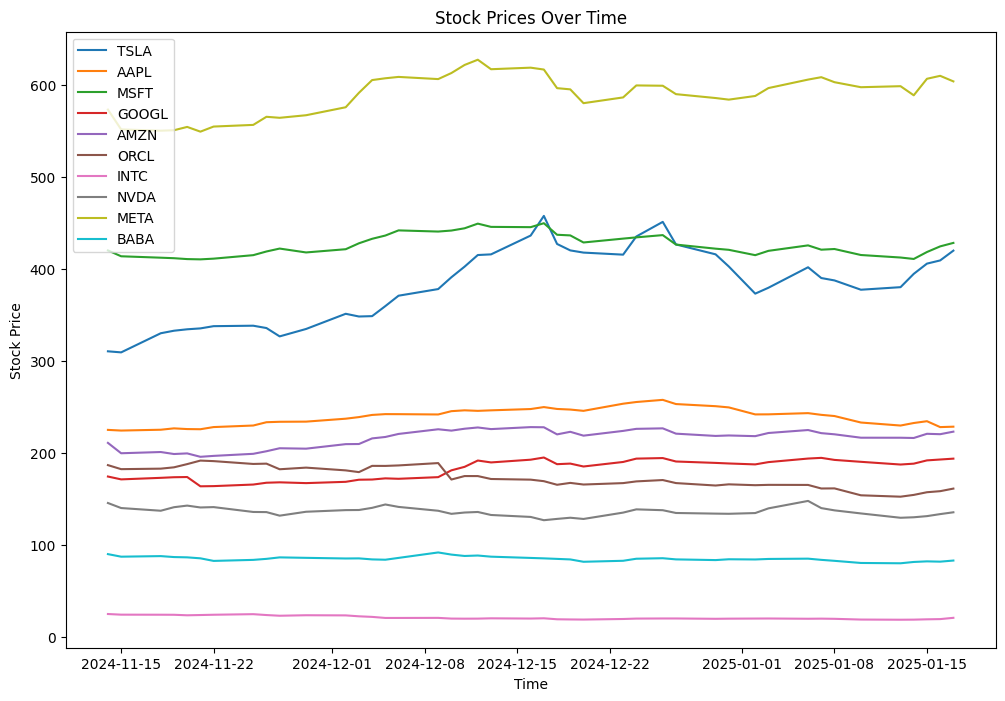

In [60]:

plt.figure(figsize=(12, 8))
for ticker in tickers:
    plt.plot(all_data[ticker].index, all_data[ticker]['close'], label=ticker)

plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.title('Stock Prices Over Time')
plt.legend()
plt.show()
